In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

import numpy as np
import pandas as pd
import sys
import re
import concurrent.futures
import tqdm
import multiprocessing
from functools import partial
import pickle

sys.path.append('/shareb/zliu/analysis/')
sys.path.append('/shareb/zliu/analysis/CHARMtools')
from CHARMtools import Cell3Ddev as Cell3D
from CHARMtools import MultiCell3D
from CHARMtools import spatialstat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_2214928/3266015118.py:32: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2]
metadata["cellname_random"] = metadata["cellname"].sample(frac=1,random_state=42).values

atac_peaks = pd.read_table("../1_preprocess/atacpeak.bed",header=None)
#atac_peaks = pd.read_table("../data/fragments/CHARMataallelespc_peaks.bed",header=None)
atac_peaks.columns = ["chrom","start","end"]
ct_peaks = pd.read_table("../data/publicdata/ENCODE/ENCFF008XKX_encode_mESCBruce4_H3K27me3.bed.gz",header=None).iloc[:,:3]
ct_peaks.columns = ["chrom","start","end"]

## Tune cluster parameters

In [3]:
def _load_cell(cellname, cellname_random, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # inpeak fragments
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    # cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname_random}.atac.frag.bed.gz",
    #                     column_name="atac_random" ,keep_3prime=True,type="allelic_resolved")
    cell.tdg["atac_random"] = cell.tdg["atac"].sample(frac=1,random_state=42).values
    cell.subset(query='atac > 0 or atac_random > 0',in_place=True)
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], metadata['cellname_random'], [5000]*len(metadata)), total=len(metadata)))

def _cluster_params_grid_search(cell):
    eps = [1.5,1.6,1.7,1.8,1.9]
    min_samples = [4,5,6,7,8,9,10,11,12]

    res = []
    for e in eps:
        for m in min_samples:
                cell.calc_3D_cluster(query = "atac > 0", eps = e, min_samples=m,cluster_name = "atac_cluster",random_seed=42)
                cell.calc_3D_cluster(query = "atac_random > 0", eps = e, min_samples=m,cluster_name = "atac_random_cluster",random_seed=42)
                cluster_number = cell.tdg["atac_cluster"].nunique() -1 
                cluster_number_random = cell.tdg["atac_random_cluster"].nunique() -1
                in_cluster_frags_number = cell.tdg.query('atac > 0 & atac_cluster != "-1"').shape[0]
                in_cluster_frags_number_random = cell.tdg.query('atac_random > 0 & atac_random_cluster != "-1"').shape[0]
                in_cluster_frags_ratio = in_cluster_frags_number / cell.tdg.query('atac > 0').shape[0]
                in_cluster_frags_ratio_random = in_cluster_frags_number_random / cell.tdg.query('atac_random > 0').shape[0]

                res.append([cell.cellname, e, m, cluster_number, in_cluster_frags_number, in_cluster_frags_ratio, cluster_number_random, in_cluster_frags_number_random, in_cluster_frags_ratio_random])
    return res

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    results = list(tqdm.tqdm(executor.map(_cluster_params_grid_search, cells), total=len(cells)))

  0%|          | 0/720 [00:00<?, ?it/s]

In [ ]:
cluster_stat_atac = pd.DataFrame([item for sublist in results for item in sublist])
cluster_stat_atac.columns = ["cellname", "eps", "min_samples", "cluster_number", "in_cluster_frags_number", "in_cluster_frags_ratio", "cluster_number_random", "in_cluster_frags_number_random", "in_cluster_frags_ratio_random"]

# group by eps, min_sample ,t-test on cluster_number and cluster_number_random
cluster_stat_atac.groupby(["eps","min_samples"]).apply(lambda x: stats.ttest_ind(x["in_cluster_frags_number"], x["in_cluster_frags_number_random"])[1]).reset_index().rename(columns={0:"p_value"}).\
    assign(log_p_value = lambda x: -np.log10(x["p_value"])).\
    pivot(index="eps",columns="min_samples",values="log_p_value")

min_samples,4,5,6,7,8,9,10,11,12
eps,,,,,,,,,
1.5,59.559740,71.051871,68.000047,55.984889,42.023948,29.093218,19.619993,12.534317,8.698550
1.6,54.901543,70.853133,73.560279,65.840084,52.982351,39.862291,28.794217,20.317363,13.941703
1.7,46.737777,65.827691,74.173087,71.703115,62.114563,50.289583,38.577473,28.782892,20.986113
1.8,37.440045,57.586441,70.666824,73.788744,68.780845,58.916301,47.943609,37.790119,28.893822
1.9,27.987373,47.474119,63.704539,72.263360,72.426179,66.189518,56.771369,47.198837,38.042139


In [ ]:
pd.set_option('display.max_columns', 100)
cluster_stat_atac.groupby(['eps','min_samples']).describe()

cluster_number                                           \
                         count         mean         std    min      25%   
eps min_samples                                                           
1.5 3                    720.0  2180.868056  643.512673  155.0  1717.75   
    4                    720.0  1050.108333  493.650926   22.0   648.00   
    5                    720.0   482.513889  324.516707    4.0   212.75   
    6                    720.0   212.386111  189.178947    0.0    63.00   
    7                    720.0    90.901389  103.219078    0.0    18.00   
    8                    720.0    38.591667   54.592407    0.0     4.00   
    9                    720.0    16.708333   29.569530    0.0     1.00   
    10                   720.0     7.500000   16.152610    0.0     0.00   
    11                   720.0     3.476389    9.248508    0.0     0.00   
    12                   720.0     1.745833    5.455406    0.0     0.00   
1.6 3                    720.0  2262.870833  533.056679  202.0  1932.00   
    4                    720.0  1223.886111  461.433168   36.0   851.00   
    5                    720.0   636.294444  355.674074    8.0   342.75   
    6                    720.0   315.790278  237.341205    1.0   116.00   
    7                    720.0   151.184722  144.599915    0.0    38.00   
    8                    720.0    71.425000   84.864925    0.0    11.00   
    9                    720.0    33.498611   48.823773    0.0     3.00   
    10                   720.0    15.940278   28.153178    0.0     1.00   
    11                   720.0     7.851389   16.798946    0.0     0.00   
    12                   720.0     3.898611    9.907331    0.0     0.00   
1.7 3                    720.0  2217.515278  451.727945  259.0  1974.75   
    4                    720.0  1324.347222  399.463477   59.0  1046.50   
    5                    720.0   767.634722  352.414278   14.0   481.75   
    6                    720.0   424.454167  269.567341    4.0   195.00   
    7                    720.0   225.831944  184.400403    0.0    72.00   
    8                    720.0   117.416667  119.046087    0.0    24.75   
    9                    720.0    60.088889   73.570761    0.0     8.00   
    10                   720.0    30.740278   45.100821    0.0     3.00   
    11                   720.0    15.955556   27.940294    0.0     1.00   
    12                   720.0     8.381944   17.511211    0.0     0.00   
1.8 3                    720.0  2072.425000  426.439009  319.0  1822.25   
    4                    720.0  1346.073611  331.051217   86.0  1156.00   
    5                    720.0   861.159722  317.482365   20.0   617.00   
    6                    720.0   524.736111  276.519174    5.0   289.00   
    7                    720.0   307.156944  213.602354    0.0   123.00   
    8                    720.0   174.427778  150.865515    0.0    50.00   
    9                    720.0    97.311111  102.123370    0.0    18.00   
    10                   720.0    53.620833   67.048645    0.0     7.00   
    11                   720.0    29.508333   43.231626    0.0     2.00   
    12                   720.0    16.394444   28.212781    0.0     1.00   
1.9 3                    720.0  1855.206944  451.734238  378.0  1547.00   
    4                    720.0  1294.029167  295.919332  113.0  1130.75   
    5                    720.0   905.181944  265.866221   28.0   731.50   
    6                    720.0   605.270833  258.411479   10.0   399.00   
    7                    720.0   386.036111  223.883914    3.0   193.00   
    8                    720.0   238.665278  175.155343    0.0    87.00   
    9                    720.0   143.901389  128.626336    0.0    37.00   
    10                   720.0    85.194444   90.554764    0.0    15.00   
    11                   720.0    50.102778   62.298603    0.0     6.00   
    12                   720.0    29.470833   42.551570    0.0     2.00   

                                        

In [38]:
def _load_cell(cellname, cellname_random, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # inpeak fragments
    cell.add_bed_data(path=f"../data/fragments/ct_frags/{cellname}.ct.frag.bed.gz",
                     column_name="ct" ,keep_3prime=True,type="allelic_resolved")
    cell.tdg["ct_random"] = cell.tdg["ct"].sample(frac=1,random_state=42).values
    cell.subset(query='ct > 0 or ct_random > 0',in_place=True)
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], metadata['cellname_random'], [5000]*len(metadata)), total=len(metadata)))

def _cluster_params_grid_search(cell):
    eps = [1.5,1.6,1.7,1.8,1.9]
    min_samples = [5,6,7,8,9,10,11,12,13,14,15]

    res = []
    for e in eps:
        for m in min_samples:
                cell.calc_3D_cluster(query = "ct > 0", eps = e, min_samples=m,cluster_name = "ct_cluster",random_seed=42)
                cell.calc_3D_cluster(query = "ct_random > 0", eps = e, min_samples=m,cluster_name = "ct_random_cluster",random_seed=42)
                cluster_number = cell.tdg["ct_cluster"].nunique() -1 
                cluster_number_random = cell.tdg["ct_random_cluster"].nunique() -1
                in_cluster_frags_number = cell.tdg.query('ct > 0 & ct_cluster != "-1"').shape[0]
                in_cluster_frags_number_random = cell.tdg.query('ct_random > 0 & ct_random_cluster != "-1"').shape[0]
                in_cluster_frags_ratio = in_cluster_frags_number / cell.tdg.query('ct > 0').shape[0]
                in_cluster_frags_ratio_random = in_cluster_frags_number_random / cell.tdg.query('ct_random > 0').shape[0]

                res.append([cell.cellname, e, m, cluster_number, in_cluster_frags_number, in_cluster_frags_ratio, cluster_number_random, in_cluster_frags_number_random, in_cluster_frags_ratio_random])
    return res

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    results = list(tqdm.tqdm(executor.map(_cluster_params_grid_search, cells), total=len(cells)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [06:38<00:00,  1.81it/s]


In [39]:
cluster_stat_ct = pd.DataFrame([item for sublist in results for item in sublist])
cluster_stat_ct.columns = ["cellname", "eps", "min_samples", "cluster_number", "in_cluster_frags_number", "in_cluster_frags_ratio", "cluster_number_random", "in_cluster_frags_number_random", "in_cluster_frags_ratio_random"]

# group by eps, min_sample ,t-test on cluster_number and cluster_number_random
cluster_stat_ct.groupby(["eps","min_samples"]).apply(lambda x: stats.ttest_ind(x["cluster_number"], x["cluster_number_random"])[1]).reset_index().rename(columns={0:"p_value"}).\
    assign(log_p_value = lambda x: -np.log10(x["p_value"])).\
    pivot(index="eps",columns="min_samples",values="log_p_value")

min_samples,5,6,7,8,9,10,11,12,13,14,15
eps,,,,,,,,,,,
1.5,1.114813,16.557674,36.648264,51.191868,55.262528,51.287451,44.705053,36.990255,30.113704,23.960299,19.716079
1.6,6.171659,3.236012,19.214174,38.330053,52.606735,57.928902,55.345534,49.971911,43.062225,35.906182,30.166919
1.7,33.417863,2.564015,4.341465,19.034420,36.616243,51.202821,58.738838,58.818983,54.113121,47.891145,41.436043
1.8,64.689472,23.496751,1.473936,4.206073,17.109345,32.696746,47.276549,56.932416,59.511123,57.069910,52.917253
1.9,69.686387,53.796980,18.827398,1.476521,3.328979,14.026356,27.694840,41.646097,52.910944,58.517385,59.194670


In [40]:
pd.set_option('display.max_columns', 100)
cluster_stat_ct.groupby(['eps','min_samples']).describe()

cluster_number                                          \
                         count         mean         std   min      25%   
eps min_samples                                                          
1.5 5                    720.0  1590.859722  580.360910   5.0  1212.00   
    6                    720.0  1022.951389  517.804976   0.0   599.25   
    7                    720.0   644.054167  437.972425   0.0   258.00   
    8                    720.0   403.844444  353.683326   0.0   110.25   
    9                    720.0   251.187500  272.196586   0.0    42.00   
    10                   720.0   157.106944  204.536978   0.0    15.00   
    11                   720.0    98.566667  150.106549   0.0     5.00   
    12                   720.0    62.491667  109.369542   0.0     2.00   
    13                   720.0    39.840278   78.678609   0.0     1.00   
    14                   720.0    25.488889   57.079135   0.0     0.00   
    15                   720.0    16.531944   41.621970   0.0     0.00   
1.6 5                    720.0  1623.562500  490.588522   8.0  1329.75   
    6                    720.0  1148.097222  447.876649   0.0   848.75   
    7                    720.0   787.559722  408.425433   0.0   444.00   
    8                    720.0   531.816667  357.237449   0.0   218.00   
    9                    720.0   356.501389  301.138891   0.0    97.75   
    10                   720.0   238.356944  245.621687   0.0    43.75   
    11                   720.0   159.430556  195.085141   0.0    17.00   
    12                   720.0   106.787500  151.310660   0.0     7.00   
    13                   720.0    71.879167  116.279856   0.0     3.00   
    14                   720.0    48.727778   88.791004   0.0     1.00   
    15                   720.0    33.223611   67.182468   0.0     0.00   
1.7 5                    720.0  1531.293056  451.468451  19.0  1219.25   
    6                    720.0  1177.379167  387.585266   2.0   942.25   
    7                    720.0   875.370833  359.893254   1.0   635.50   
    8                    720.0   633.663889  332.347583   0.0   356.75   
    9                    720.0   453.463889  299.476082   0.0   185.75   
    10                   720.0   322.212500  261.481657   0.0    92.75   
    11                   720.0   228.562500  223.185950   0.0    43.00   
    12                   720.0   161.783333  185.270055   0.0    19.00   
    13                   720.0   114.691667  151.498594   0.0     9.00   
    14                   720.0    81.304167  121.849792   0.0     4.00   
    15                   720.0    58.170833   97.981705   0.0     2.00   
1.8 5                    720.0  1350.930556  447.518332  37.0  1019.50   
    6                    720.0  1121.655556  356.407926   7.0   866.50   
    7                    720.0   897.211111  314.787793   2.0   699.50   
    8                    720.0   695.529167  293.785493   0.0   502.50   
    9                    720.0   528.977778  276.009150   0.0   301.75   
    10                   720.0   396.437500  254.079333   0.0   167.75   
    11                   720.0   296.126389  228.843830   0.0    88.00   
    12                   720.0   220.352778  201.855311   0.0    45.75   
    13                   720.0   163.555556  174.599298   0.0    22.00   
    14                   720.0   121.088889  148.317529   0.0    11.00   
    15                   720.0    90.350000  124.423577   0.0     5.00   
1.9 5                    720.0  1123.948611  440.549134  49.0   753.00   
    6                    720.0   998.825000  350.769442  15.0   738.00   
    7                    720.0   855.637500  291.332435   4.0   640.00   
    8                    720.0   708.920833  260.197428   0.0   542.00   
    9                    720.0   572.448611  245.275855   0.0   407.75   
    10                   720.0   453.373611  231.424116   0.0   271.50   
    11                   720.0   355.458333  217.857524   0.0   162.00   
    12              

## Acc Cluster example

In [406]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")
    
    # random 
    cell.tdg["atac_random"] = cell.tdg["atac"].sample(frac=1, random_state=42).reset_index(drop=True)

    #cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    #cell.add_feature_in_radius(feature="atac_random",radius=2,type="sum",if_self=True)
    
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    e = 1.7
    m = 6
    cell.calc_3D_cluster(query = "atac > 0", eps = e, min_samples=m,cluster_name = "atac_cluster",random_seed=42)
    cell.calc_3D_cluster(query = "atac_random > 0", eps = e, min_samples=m,cluster_name = "atac_random_cluster",random_seed=42)
    return cell

cell = _load_cell("P4066", 5000)

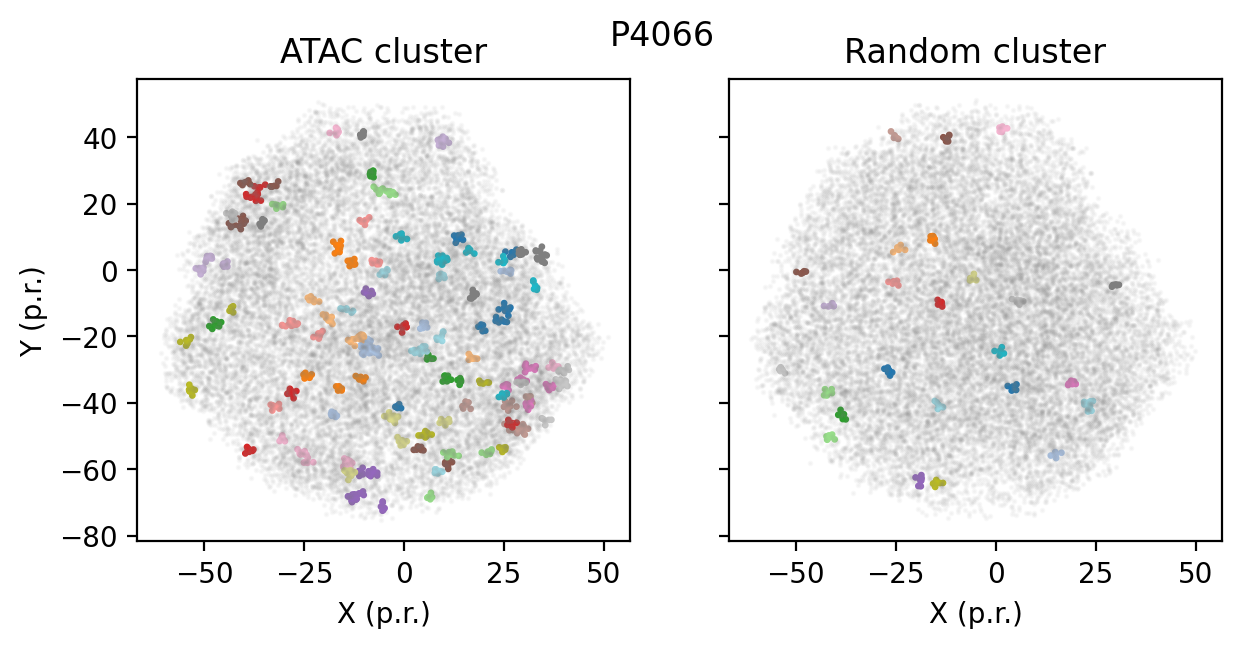

In [412]:
random_atac = cell.tdg.query('atac_random > 0')
atac = cell.tdg.query('atac > 0')

# scatter plot, color by atac_cluster, remove legend
fig,ax = plt.subplots(figsize=(7,3),ncols=2,nrows=1,sharex=True,sharey=True)
ax[0].scatter(x="x",y="y",data=atac.query('atac_cluster != "-1"'),alpha=1,c=atac.query('atac_cluster != "-1"')["atac_cluster"].values.astype("int"), cmap="tab20",s=2)
ax[0].scatter(x="x",y="y",data=cell.tdg.query('atac_cluster == "-1"').sample(20000),alpha=0.05,c="grey",s=1)
ax[0].set_title("ATAC cluster")

ax[1].scatter(x="x",y="y",data=random_atac.query('atac_random_cluster != "-1"'),alpha=1,c=random_atac.query('atac_random_cluster != "-1"')["atac_random_cluster"].values.astype("int"), cmap="tab20",s=2)
ax[1].scatter(x="x",y="y",data=cell.tdg.query('atac_random_cluster == "-1"').sample(20000),alpha=0.05,c="grey",s=1,rasterized=True)
ax[1].set_title("Random cluster")

ax[1].set_xlabel("X (p.r.)")
ax[0].set_xlabel("X (p.r.)")
ax[0].set_ylabel("Y (p.r.)")

plt.suptitle("P4066")
plt.savefig("figures/ATACcluster_example.pdf", bbox_inches='tight')

## 对Acc Cluster 的描述信息

In [3]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # inpeak fragments
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")

    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                 column_name="atac_inpeaks" ,keep_3prime=True,type="allelic_resolved",peaks=atac_peaks,flank=200)
    
    cell.subset(query='atac > 0',in_place=True)
    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)
    cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [01:37<00:00,  7.35it/s]


In [4]:
clustered_frips = []
non_cluster_frips = []
cluster_sizes = []
for cell in tqdm.tqdm(cells):
    temp_tdg = cell.get_data().query('atac_cluster != "-1"')
    clustered_frips.append(temp_tdg["atac_inpeaks"].sum() / temp_tdg["atac"].sum())
    cluster_sizes.append( cell.get_data().query('atac_cluster != "-1"').groupby('atac_cluster').size().values)
    temp_tdg = cell.get_data().query('atac_cluster == "-1"')
    non_cluster_frips.append(temp_tdg["atac_inpeaks"].sum() / temp_tdg["atac"].sum())

  0%|          | 0/720 [00:00<?, ?it/s]

100%|██████████| 720/720 [00:33<00:00, 21.26it/s]


In [5]:
np.median(np.concatenate(cluster_sizes))

7.0

Wilcoxon test statistic: 253417.0, p-value: 5.746049833616548e-109


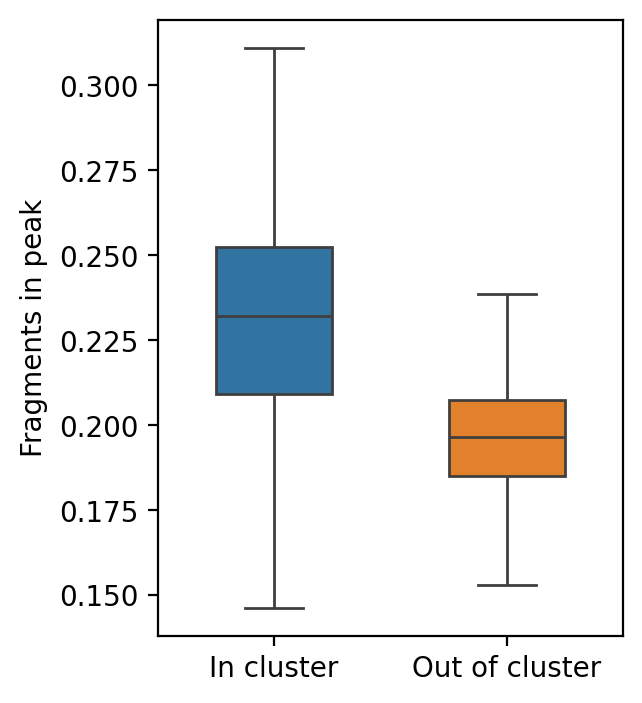

In [6]:
pdata = pd.DataFrame({'in_cluster': clustered_frips, 'out_of_cluster': non_cluster_frips})
fig = plt.figure(figsize=(3, 4))
sns.boxplot(data=pdata,showfliers=False,width=0.5)
plt.ylabel('Fragments in peak')
plt.xticks([0, 1], ['In cluster', 'Out of cluster'])
stat, p = stats.wilcoxon(clustered_frips, non_cluster_frips, alternative='greater')
print(f"Wilcoxon test statistic: {stat}, p-value: {p}")

In [7]:
def _calc_radius_gyration(tdg):
    """
    Calculate the radius of gyration for a given tdg
    """
    # calculate the center of mass
    com = np.array([tdg["x"].mean(), tdg["y"].mean(), tdg["z"].mean()])
    # calculate the distance from each point to the center of mass
    distances = np.sqrt((tdg["x"] - com[0])**2 + (tdg["y"] - com[1])**2 + (tdg["z"] - com[2])**2)
    # calculate the radius of gyration
    rg = np.sqrt(np.sum(distances**2) / len(distances))
    return rg

# calc radius gyration for each cluster
def _calc_cluster_radius_gyration(tdg):
    cluster = tdg.groupby('atac_cluster').apply(lambda x: _calc_radius_gyration(x)).reset_index()
    cluster.columns = ["cluster","rg"]
    return cluster

rg_res = []
for cell in cells:
    temp_tdg = cell.get_data().query('atac > 0 & atac_cluster != "-1"').copy()
    temp_tdg = _calc_cluster_radius_gyration(temp_tdg)
    temp_tdg["cellname"] = cell.cellname
    rg_res.append(temp_tdg)
rg_res = pd.concat(rg_res)

In [8]:
rg_res["rg"].describe()

count    305607.000000
mean          1.416664
std           0.497874
min           0.000000
25%           1.153243
50%           1.282512
75%           1.524289
max          19.210129
Name: rg, dtype: float64

## 2D~3D cluster

In [ ]:
# refer to the local_enrich_region.ipynb

## Feature Enrichment

In [3]:
acd2d_30k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/atac30kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
acd2d_30k.columns = ['chrom', 'start', 'end']
me3d2d_300k = pd.read_csv('./rich_regions/rose_strict_share/charm_res/ct300kwithp_Gateway_SuperEnhancers.bed', sep='\t', header=None).iloc[:, :3]
me3d2d_300k.columns = ['chrom', 'start', 'end']

In [4]:
def _load_cell(cellname, resolution):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    # inpeak fragments
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
                     column_name="atac" ,keep_3prime=True,type="allelic_resolved")

    # cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
    #              column_name="atac_inpeaks" ,keep_3prime=True,type="allelic_resolved",peaks=atac_peaks,flank=200)
    #cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz",
    #             column_name="atac_in2dcluster" ,keep_3prime=True,type="allelic_resolved",peaks=acd2d_30k,flank=0)
        
    cell.add_bed_data(
        path=f"../1_preprocess/atacpeak.bed",
        #path="../data/fragments/CHARMataallelespc_peaks.bed",
        column_name="atac_peaks",keep_3prime=False,
        type="all"
    )
    #cell.subset(query='atac > 0',in_place=True)
    cell.subset(query='atac > 0 or atac_peaks > 0',in_place=True)
    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)

    cell.tdg["atac_3dcluster_particle"] = cell.tdg["atac_cluster"].apply(lambda x: 1 if x != "-1" else 0)
    #cell.tdg["atac_2dcluster_particle"] = cell.tdg["atac_in2dcluster"].apply(lambda x: 1 if x > 0 else 0)

    cell.add_feature_in_radius(feature="atac_3dcluster_particle",radius=2,type="sum",if_self=True)
    #cell.add_feature_in_radius(feature="atac_2ddcluster_particle",radius=2,type="sum",if_self=True)
    
    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [02:49<00:00,  4.26it/s]


In [5]:
pd.set_option('display.max_columns', None)
encode_metadata = pd.read_csv("./encode/metadata.tsv",sep='\t')
encode_metadata = encode_metadata[["File accession","Experiment target","Biosample term name"]]

encode_metadata.head()

encode_metadata = pd.concat([
                                pd.DataFrame([
                                            ["GSE94300E14Ezh2","Ezh2","mESC"],
                                            ["GSE96107Ring1B","Ring1B","mESC"],
                                            ["SRR7262948Med1","Med1","mESC"],
                                            ["Whyte2013SE","Super Enhancers","mESC"],
                                            ["klf4","Klf4","mESC"],
                                            ["GSM3123485Sox2","Sox2","mESC"],
                                            ["GSM4984767_ctr_rep_spikeIn_Brd2","Brd2","mESC"],
                                            ["GSM4984768_ctr_rep_spikeIn_Brd3","Brd3","mESC"],
                                            ["GSM4984769_ctr_rep_spikeIn_Brd4","Brd4","mESC"],
                                            ["GSM4984770_ctr_rep_spikeIn_Rad21","Rad21","mESC"],
                                            ["SRR7262956PolIIr2","PolII","mESC"]
                                            ],
                                            columns=["File accession","Experiment target","Biosample term name"]),encode_metadata],axis=0)

encode_metadata.head()
encode_metadata["Biosample term name"] = encode_metadata["Biosample term name"].astype("category")
encode_metadata["Biosample term name"] = encode_metadata["Biosample term name"].cat.set_categories(["mESC","ES-Bruce4","ES-E14","E14TG2a.4"])
encode_metadata.sort_values("Biosample term name",inplace=True)
encode_metadata = encode_metadata.groupby("Experiment target").first().reset_index()
encode_metadata["Experiment target"] = encode_metadata["Experiment target"].str.replace("-mouse","")

In [6]:
def calc_accession(accession_id):
    encode_peak = pd.read_csv(f"./encode/{accession_id}.bed.gz",sep='\t',header=None,skiprows=1).iloc[:,:3]
    encode_peak.columns = ["chrom","start","end"]
    encode_peak['pos'] = (encode_peak['start'] + encode_peak["end"]) / 2 // 5000 * 5000
    encode_peak = encode_peak[['chrom','pos']]
    encode_peak = pd.concat(
        [
            encode_peak.assign(chrom = encode_peak['chrom'] + 'a').copy(),
            encode_peak.assign(chrom = encode_peak['chrom'] + 'b').copy()
        ]
    ).reset_index(drop=True)
    encode_peak["count"] = 1
    encode_peak.drop_duplicates(inplace=True)

    res3d = []
    #for cell in tqdm.tqdm(cells):
    for cell in cells:
        temp_df = cell.get_data().query('atac_peaks > 0').copy()
        temp_df["atac_inpeak3d"] = temp_df.apply(lambda x: "1" if (x['atac_3dcluster_particle_sum_in_radius_2'] > 5) else "-1", axis=1)
        #temp_df["atac_inpeak3d"] = temp_df.apply(lambda x: "1" if x["atac_cluster"] != "-1" else "-1", axis=1)
        #temp_df["atac_inpeak3d"] = temp_df.apply(lambda x: "1" if x["atac_2dcluster_particle"] == 1 else "-1", axis=1)

        temp_df = temp_df.merge(encode_peak,how='left',on=['chrom','pos']).fillna(0)

        peak_in_cluster = temp_df.query("atac_inpeak3d == '1' & count > 0").shape[0]
        not_peak_in_cluster = temp_df.query("atac_inpeak3d == '1' & count == 0").shape[0]
        peak_not_in_cluster = temp_df.query("atac_inpeak3d == '-1' & count > 0").shape[0]
        not_peak_not_in_cluster = temp_df.query("atac_inpeak3d == '-1' & count == 0").shape[0]

        oddsratio,pv = stats.fisher_exact(
            [[peak_in_cluster,not_peak_in_cluster],[peak_not_in_cluster,not_peak_not_in_cluster]]

        )
        res3d.append((cell.cellname,oddsratio,pv,peak_in_cluster,not_peak_in_cluster,peak_not_in_cluster,not_peak_not_in_cluster))

    res3d = pd.DataFrame(res3d,columns=["cellname","oddsratio","pv","peak_in_cluster","not_peak_in_cluster","peak_not_in_cluster","not_peak_not_in_cluster"])


    res3d["cluster_type"] = "3D"

    res3d["accession"] = accession_id

    return res3d

accession_ids = encode_metadata["File accession"].values

with concurrent.futures.ProcessPoolExecutor(max_workers=15) as executor:
    res = list(tqdm.tqdm(executor.map(calc_accession, accession_ids), total=len(accession_ids)))


100%|██████████| 28/28 [23:25<00:00, 50.19s/it]  


/tmp/ipykernel_1224594/2340300491.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


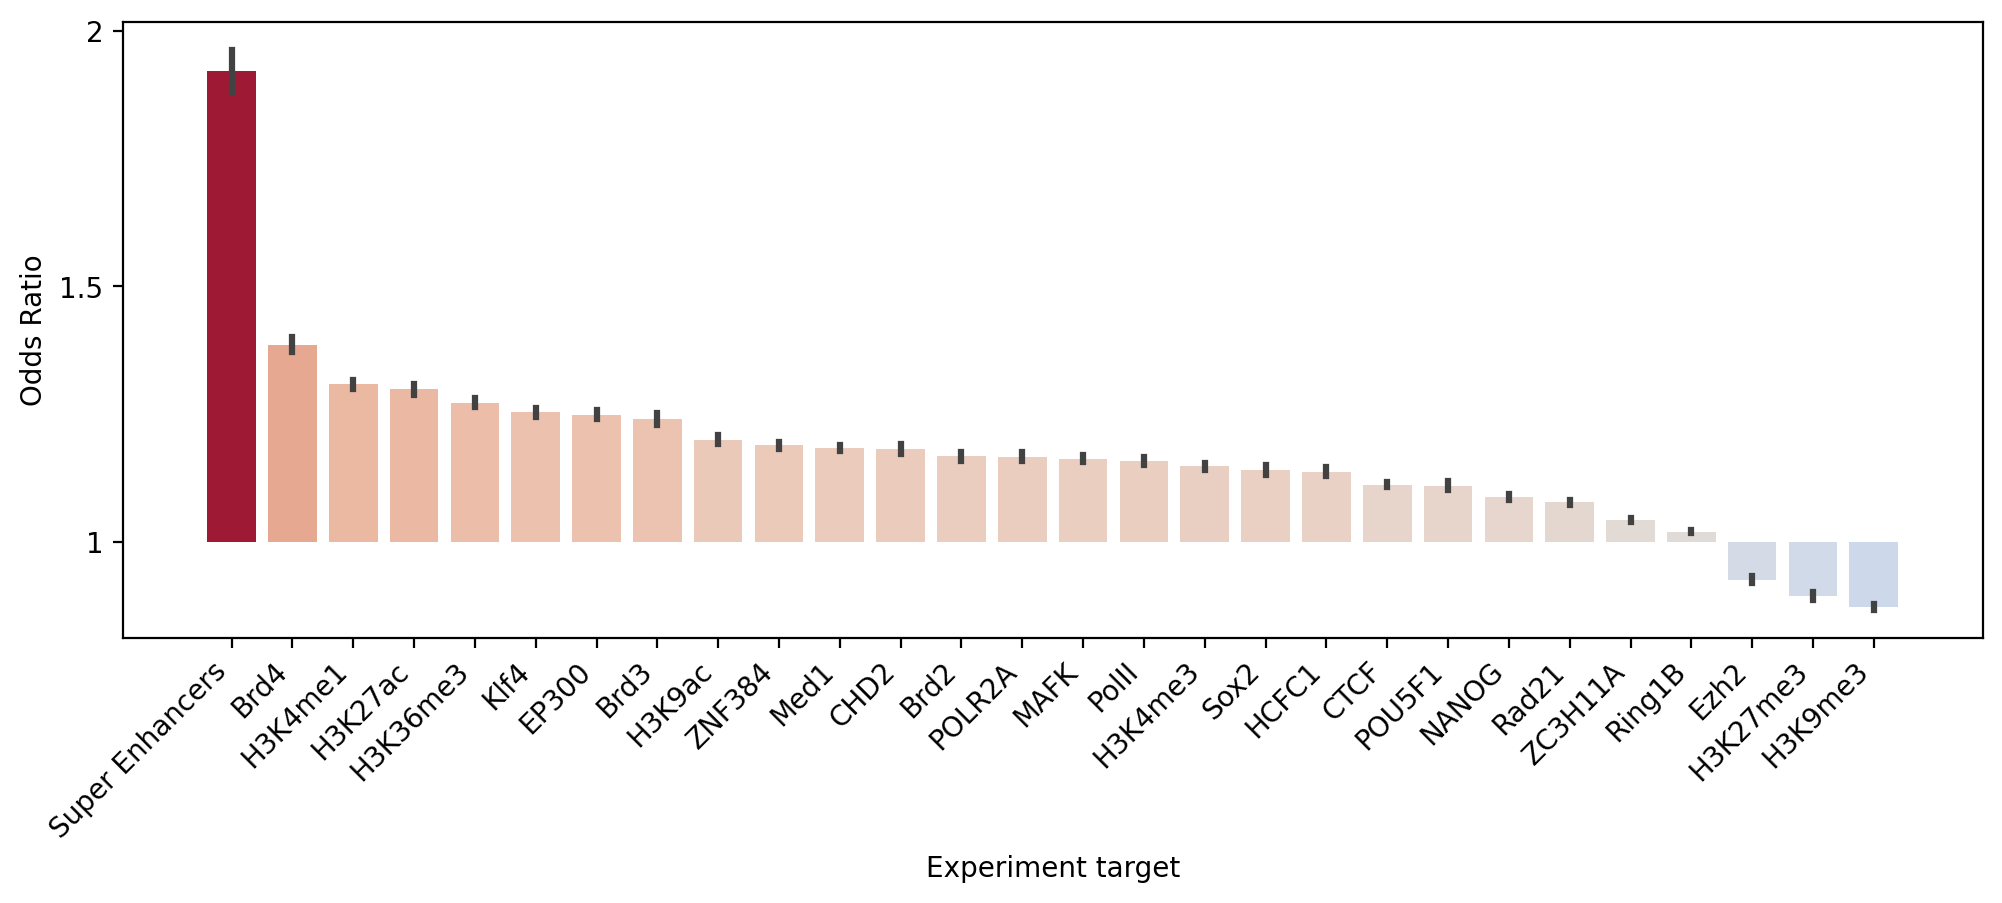

In [7]:
res_df = pd.concat(res)
#res_df = res_df.groupby(["accession","cluster_type"]).agg({"oddsratio":"mean"})
pdata = res_df.merge(encode_metadata, left_on="accession", right_on="File accession")
accession_order = pdata.groupby('Experiment target')['oddsratio'].mean().sort_values(ascending=False).index
pdata['adjusted_oddsratio'] = pdata['oddsratio'] - 1

aggregated_data = pdata.groupby('Experiment target')['adjusted_oddsratio'].mean().reset_index()
cmap = sns.color_palette("coolwarm", as_cmap=True)
aggregated_data['color'] = aggregated_data['adjusted_oddsratio'].apply(lambda x: cmap(0.5 + x / 1.7))


plt.figure(figsize=(12, 4))
sns.barplot(
    x='Experiment target', 
    y='adjusted_oddsratio', 
    data=pdata, 
    errorbar=('se'), 
    palette=aggregated_data.set_index('Experiment target')['color'].to_dict(), 
    order=accession_order
)

plt.yticks([-0.5, 0, 0.5, 1], ['0.5', '1','1.5', '2'])
#plt.ylim(-1,3.5)
plt.ylabel('Odds Ratio')
plt.xticks(rotation=45, ha='right')
plt.plot()
plt.savefig("figures/ACD_enrichment_3D.pdf",bbox_inches='tight')

## RNA

In [16]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2].reset_index(drop=True)

atac_peaks = pd.read_table("../1_preprocess/atacpeak.bed",header=None)
atac_peaks.columns = ["chrom","start","end"]

rnag1 = pd.read_csv("../data/RNAmats/counts.gene.genome1.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("../data/RNAmats/counts.gene.genome2.format.tsv.gz",sep='\t')
genes = pd.read_csv("./transcripts.bed",sep='\t',header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["ids"] = "."
genes = genes[["chrom","start","end","ids","name","strand"]]
# keep genes in chr1-19+ chrX
chroms = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9",
            "chr10","chr11","chr12","chr13","chr14","chr15","chr16",
            "chr17","chr18","chr19","chrX"]
genes = genes[genes["chrom"].isin(chroms)].reset_index(drop=True)


rnamerge = rnag1.set_index("gene") + rnag2.set_index("gene")
rnamerge = rnamerge.fillna(0)
rnamerge = rnamerge[metadata["cellname"].values]
considered_genes = (rnamerge > 0).sum(axis=1).sort_values(ascending=False) > 0.20 * rnamerge.shape[1]
considered_genes = considered_genes[considered_genes].index.values
considered_genes = list(set(considered_genes) & set(genes["name"].values))

tss = genes.copy()
tss.query('name in @considered_genes',inplace=True)
tss["tss"] = tss.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"],axis=1)
tss["tssn"] = tss["tss"] + 1
tss = tss[["chrom","tss","tssn"]]
tss.to_csv("tss.bed",sep='\t',header=None,index=None)

cellnames = metadata["cellname"].values
rnag1 = rnag1.set_index("gene")
rnag2 = rnag2.set_index("gene")
rnag1 = rnag1.loc[considered_genes, cellnames]
rnag2 = rnag2.loc[considered_genes, cellnames]
rnag1 = rnag1.reset_index()
rnag2 = rnag2.reset_index()

In [17]:
def _load_cell(cellname, resolution,subset=True):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", 
                     column_name="atac",keep_3prime=True)

    cell.add_bed_data(path=f"tss.bed", column_name="tss",type="all",keep_3prime=False)

    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes)

    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    if subset:
       cell.subset(query="tss > 0 or atac > 0", in_place=True)

    cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="UMI",radius=2,type="sum",if_self=True)
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=150) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [01:12<00:00,  9.89it/s]


In [18]:
cluster3d_umi = []
noncluster3d_umi = []
for cell in tqdm.tqdm(cells):
    df = cell.get_data().copy()
    df["if_3d_cluster"] = cell.tdg["atac_sum_in_radius_2"].apply(lambda x: True if x > 5 else False)
    cluster3d_umi.append(df.query('if_3d_cluster & atac > 0')["UMI_sum_in_radius_2"].mean())
    noncluster3d_umi.append(df.query('not if_3d_cluster & atac > 0')["UMI_sum_in_radius_2"].mean())

pdata = pd.DataFrame({
    'cluster': cluster3d_umi,
    'out_of_cluster': noncluster3d_umi,
})


100%|██████████| 720/720 [00:10<00:00, 70.74it/s]


In [19]:
pdata = pdata.melt(var_name='type', value_name='UMI')

/tmp/ipykernel_1231117/1363461717.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=pdata, x="type", y="UMI" ,gap=0.2,showfliers=False, palette="Set1", width=0.7)


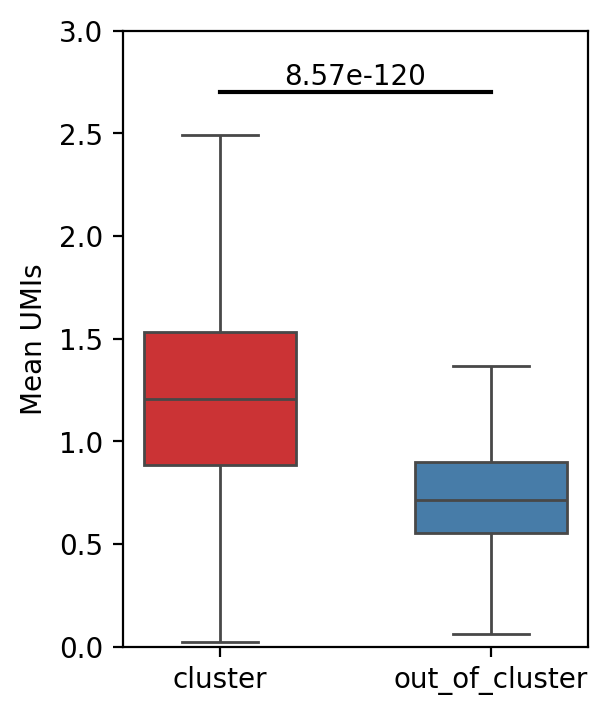

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(3, 4))
ax = sns.boxplot(data=pdata, x="type", y="UMI" ,gap=0.2,showfliers=False, palette="Set1", width=0.7)


p_3d = stats.wilcoxon(cluster3d_umi, noncluster3d_umi,alternative="greater").pvalue

def add_stat_annotation(ax, x1, x2, y, p_value, text_offset=0.01):
    significance = ""
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = "ns"
    
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # 添加横线
    ax.text((x1 + x2) / 2, y + text_offset, f"{p_value:.2e}", ha='center', va='bottom')

add_stat_annotation(ax, 0, 1, 2.7, p_3d)

plt.ylabel('Mean UMIs')
plt.xlabel('')

plt.ylim(0,3)
plt.savefig('figures/meanUMIs.pdf', bbox_inches='tight')
plt.show()

## In same gene

In [ ]:
metadata = pd.read_csv('../data/metadata/metadata.tsv', sep='\t')
metadata = metadata[metadata['5k'] < 2].reset_index(drop=True)

metadata = metadata.sort_values(by=['order']).reset_index(drop=True)
metadata["cellnext"] = metadata["cellname"].sample(frac=1,random_state=42).values

atac_peaks = pd.read_table("../1_preprocess/atacpeak.bed",header=None)
atac_peaks.columns = ["chrom","start","end"]

rnag1 = pd.read_csv("../data/RNAmats/counts.gene.genome1.format.tsv.gz",sep='\t')
rnag2 = pd.read_csv("../data/RNAmats/counts.gene.genome2.format.tsv.gz",sep='\t')
genes = pd.read_csv("./transcripts.bed",sep='\t',header=None)
genes.columns = ["chrom","start","end","name","strand"]
genes["ids"] = "."
genes = genes[["chrom","start","end","ids","name","strand"]]
# keep genes in chr1-19+ chrX
chroms = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9",
            "chr10","chr11","chr12","chr13","chr14","chr15","chr16",
            "chr17","chr18","chr19","chrX"]
genes = genes[genes["chrom"].isin(chroms)].reset_index(drop=True)


rnamerge = rnag1.set_index("gene") + rnag2.set_index("gene")
rnamerge = rnamerge.fillna(0)
rnamerge = rnamerge[metadata["cellname"].values]

considered_genes = (rnamerge > 0).sum(axis=1).sort_values(ascending=False) > 0.10 * rnamerge.shape[1]
considered_genes = considered_genes[considered_genes].index.values
considered_genes = list(set(considered_genes) & set(genes["name"].values))

tss = genes.copy()
tss.query('name in @considered_genes',inplace=True)
tss["tss"] = tss.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"],axis=1)
tss["tssn"] = tss["tss"] + 1
tss = tss[["chrom","tss","tssn"]]
tss.to_csv("tss.bed",sep='\t',header=None,index=None)

In [ ]:
cellnames = metadata["cellname"].values

rnag1 = rnag1.set_index("gene")
rnag2 = rnag2.set_index("gene")
rnag1 = rnag1.loc[considered_genes, cellnames]
rnag2 = rnag2.loc[considered_genes, cellnames]
rnag1 = rnag1.T
rnag2 = rnag2.T
rnag1 = np.log1p(rnag1) *10000
rnag2 = np.log1p(rnag2) *10000 
rnag1 = (rnag1 - rnag1.mean()) / rnag1.std()
rnag2 = (rnag2 - rnag2.mean()) / rnag2.std()
rnag1 = rnag1.fillna(0)
rnag2 = rnag2.fillna(0)

rnag1 = rnag1.T.reset_index()
rnag2 = rnag2.T.reset_index()

In [5]:
def _load_cell(cellname,cellname_next, resolution,subset=True):
    cell = Cell3D.Cell3D(
        cellname = cellname,
        resolution = int(resolution),
        tdg_path = f"../data/tdg/{cellname}.5k.3dg.gz",
    )
    cell.add_bed_data(path=f"../data/fragments/atac_frags/{cellname}.atac.frag.bed.gz", 
                     column_name="atac",keep_3prime=True)

    cell.add_bed_data(path=f"tss.bed", column_name="tss",type="all",keep_3prime=False)

    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes,cellname = cellname,column_name="UMI")
    cell.add_RNA_data(rnag1 = rnag1, rnag2 = rnag2, genes = genes,cellname = cellname_next,column_name="UMI_next")


    cell.add_chrom_length(chrom_length_path = "/share/Data/public/ref_genome/mouse_ref/M23/raw_data/chr.dip.len")

    if subset:
       cell.subset(query="tss > 0 or atac > 0", in_place=True)

    cell.calc_3D_cluster(query = "atac > 0", eps = 1.7, min_samples=6,cluster_name = "atac_cluster",random_seed=42)
    cell.tdg["atac_cluster_particle"] = cell.tdg["atac_cluster"].apply(lambda x: 1 if x != "-1" else 0)
    cell.add_feature_in_radius(feature="atac_cluster_particle",radius=2,type="sum",if_self=True)

    cell.add_feature_in_radius(feature="atac",radius=2,type="sum",if_self=True)
    cell.add_feature_in_radius(feature="UMI",radius=2,type="sum",if_self=True)
    return cell

with concurrent.futures.ProcessPoolExecutor(max_workers=128) as executor:
    cells = list(tqdm.tqdm(executor.map(_load_cell, metadata['cellname'], metadata['cellnext'], [5000]*len(metadata)), total=len(metadata)))

100%|██████████| 720/720 [01:55<00:00,  6.23it/s]


In [6]:
dfs_next = []
dfs = []
for cell in tqdm.tqdm(cells):
    df = cell.tdg.query("tss > 0")[["chrom","pos","UMI_next","atac_cluster_particle_sum_in_radius_2"]].copy()
    df.columns = ["chrom","pos","UMI","atac_sum_in_radius_2"]
    df["cellname"] = cell.cellname
    dfs_next.append(df)

    df = cell.tdg.query("tss > 0")[["chrom","pos","UMI","atac_cluster_particle_sum_in_radius_2"]].copy()
    df.columns = ["chrom","pos","UMI","atac_sum_in_radius_2"]
    df["cellname"] = cell.cellname
    dfs.append(df)


df = pd.concat(dfs)
df["in_acd"] = df["atac_sum_in_radius_2"].apply(lambda x: "UMI_in_acd" if x > 5 else "UMI_out_acd")
# remove last character in chrom
df["chrom"] = df["chrom"].apply(lambda x: x[:-1])
dfsummarise = df.groupby(["chrom","pos","in_acd"]).agg({"UMI":"mean"}).reset_index()
dfsummarise = dfsummarise.pivot_table(index=["chrom","pos"],columns="in_acd",values="UMI").reset_index()
dfsummarise = dfsummarise.dropna()
dfsummarise_filter = dfsummarise.copy()

df_next = pd.concat(dfs_next)
df_next["in_acd"] = df_next["atac_sum_in_radius_2"].apply(lambda x: "UMI_in_acd" if x > 5 else "UMI_out_acd")
df_next["chrom"] = df_next["chrom"].apply(lambda x: x[:-1])
dfsummarise_next = df_next.groupby(["chrom","pos","in_acd"]).agg({"UMI":"mean"}).reset_index()
dfsummarise_next = dfsummarise_next.pivot_table(index=["chrom","pos"],columns="in_acd",values="UMI").reset_index()
dfsummarise_next = dfsummarise_next.dropna()
dfsummarise_next_filter = dfsummarise_next.copy()

merge_df = dfsummarise.merge(dfsummarise_next,on=["chrom","pos"],suffixes=('_thiscell','_othercell'))

100%|██████████| 720/720 [00:06<00:00, 103.64it/s]


In [7]:
merge_df["diff_thiscell"] = merge_df["UMI_in_acd_thiscell"] - merge_df["UMI_out_acd_thiscell"]
merge_df["diff_othercell"] =merge_df["UMI_in_acd_othercell"] - merge_df["UMI_out_acd_othercell"]

# sort by diff_thiscell
merge_df = merge_df.sort_values(by=["diff_thiscell"],ascending=True).reset_index(drop=True)
merge_df["rank"] = merge_df.index + 1



merge_df = merge_df.sort_values(by=["diff_othercell"],ascending=True).reset_index(drop=True)
merge_df["rank_othercell"] = merge_df.index + 1

Genes with higher expression in 3D clusters(thiscell) : 61.33333333333333%


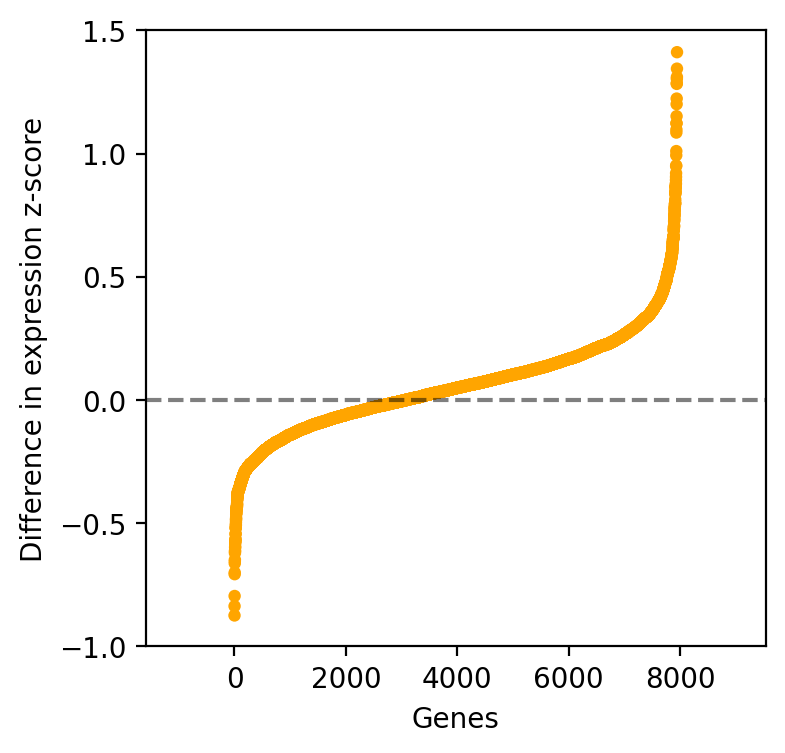

In [ ]:
plt.figure(figsize=(4, 4))

sns.scatterplot(data=merge_df, x="rank", y="diff_thiscell", color='orange',edgecolor='none',s=20,rasterized=True)
plt.axhline(y=0, linestyle='--',alpha=0.5,color="black")
plt.xlabel('Genes')
plt.ylabel('Difference in expression z-score')
print("Genes with higher expression in 3D clusters(thiscell) : " + str(merge_df.query('diff_thiscell > 0').shape[0] / merge_df.shape[0] * 100) + "%")
plt.margins(x=0.2) 
plt.ylim(-1,1.5)

# save 
plt.savefig("figures/zscorediff_inoutacd.pdf", bbox_inches='tight')

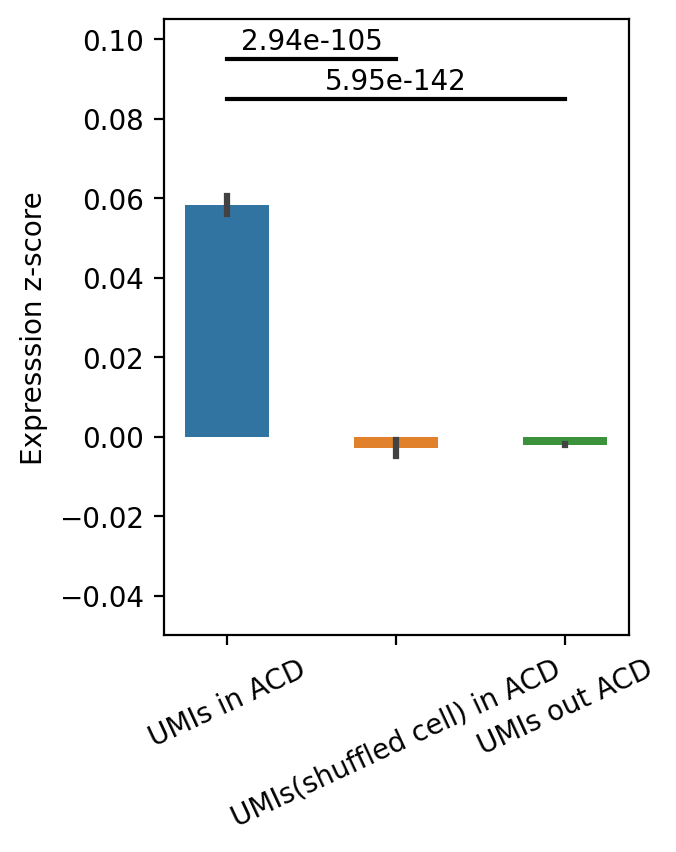

In [9]:
def add_stat_annotation(ax, x1, x2, y, p_value, text_offset=0.001):
    significance = ""
    if p_value < 0.001:
        significance = "***"
    elif p_value < 0.01:
        significance = "**"
    elif p_value < 0.05:
        significance = "*"
    else:
        significance = "ns"
    
    ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # 添加横线
    ax.text((x1 + x2) / 2, y + text_offset, f"{p_value:.2e}", ha='center', va='bottom')


%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(3,4))
pdata = merge_df[["UMI_in_acd_thiscell","UMI_in_acd_othercell","UMI_out_acd_thiscell"]]
pdata.columns = ["UMIs in ACD","UMIs(shuffled cell) in ACD","UMIs out ACD"]

ax = sns.barplot(data=pdata, errorbar="se",width=0.5)
plt.xticks(rotation=25)

p1 = stats.wilcoxon(merge_df["UMI_in_acd_thiscell"],merge_df["UMI_in_acd_othercell"],alternative="greater")[1]
add_stat_annotation(ax, 0, 1, 0.095, p1)
p2 = stats.wilcoxon(merge_df["UMI_in_acd_thiscell"],merge_df["UMI_out_acd_thiscell"],alternative="greater")[1]
add_stat_annotation(ax, 0, 2, 0.085, p2)

plt.ylabel("Expresssion z-score")
plt.xlabel("")
plt.ylim(-0.-0.05,0.105)
plt.plot()
plt.savefig('figures/expressionzscore_allele_specific_inoutacd.pdf', bbox_inches='tight')